# LSTM

## Read data

In [1]:
import os

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Subset
import torch
from torchtune.datasets import ConcatDataset
import optuna
import lightning.pytorch as pl
from electricity_price_forecast.data.dataset import DatasetWithWindow
from electricity_price_forecast.model.lstm_model import LSTMModel
from electricity_price_forecast.model.torch_lightning_module import TorchLightningModule
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from electricity_price_forecast.data.datamodule import Datamodule
import logging

logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

VAL_RATIO = 0.2
TESTED_HORIZONS = [6, 12, 24, 48, 72, 168]

df_price = pd.read_parquet("../data/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_00257 = pd.read_parquet("../data/scenarios synthetiques/prix/00257.parquet")

import error: No module named 'triton'


d:\Programs\Anaconda\envs\air_liquide_ai_challenge\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(df_price.index.min())
print(df_price.index.max())
df_price.head()

0
35063


,date,price
0,2016-12-31 23:00:00+00:00,58.82
1,2017-01-01 00:00:00+00:00,58.23
2,2017-01-01 01:00:00+00:00,51.95
3,2017-01-01 02:00:00+00:00,47.27
4,2017-01-01 03:00:00+00:00,45.49


In [3]:
print(df_price_generated_00257["dayofweek"].min())
print(df_price_generated_00257["dayofweek"].max())
df_price_generated_00257.head()

0
6


,price,dayofweek,hourofday
0,31.66,0,0
1,31.06,0,1
2,27.81,0,2
3,27.54,0,3
4,25.04,0,4


## Preprocess data

In [4]:
def preprocess_true_data(df):
    reference_date = pd.to_datetime("2016-12-31 00:00:00+00:00")
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - reference_date).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [5]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head()

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,1,24
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,1,25
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,1,26
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,1,27


In [6]:
def preprocess_synthetic_data(df):
    new_df = df.copy()
    new_df['dayofseries'] = 0
    
    day = -1
    for i in range(0, len(new_df)):
        if i % 24 == 0:
            day += 1
        new_df.loc[i, 'dayofseries'] = day
    
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [7]:
df_price_generated_00257_preprocessed = preprocess_synthetic_data(df_price_generated_00257)
df_price_generated_00257_preprocessed.head()

,price,dayofweek,hourofday,dayofseries,hoursofseries
0,31.66,0,0,0,0
1,31.06,0,1,0,1
2,27.81,0,2,0,2
3,27.54,0,3,0,3
4,25.04,0,4,0,4


## Plot data

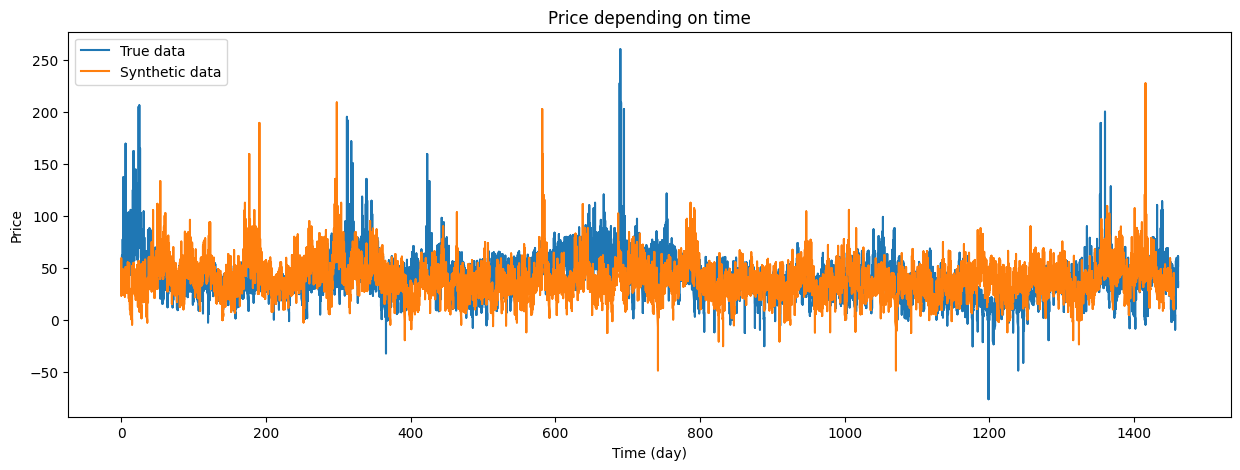

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df_price_preprocessed["dayofseries"], df_price_preprocessed["price"], label="True data")
plt.plot(df_price_generated_00257_preprocessed["dayofseries"], df_price_generated_00257_preprocessed["price"], label="Synthetic data")
plt.title('Price depending on time')
plt.xlabel('Time (day)')
plt.ylabel('Price')
plt.legend()

plt.show()

## Training functions

In [9]:
def get_best_params(datamodule, n_trials=50):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: train_model(
        datamodule,
        lr=trial.suggest_float("lr", 1e-5, 1e-1),
        n_epochs=100,
        hidden_dim=trial.suggest_int("hidden_dim", 16, 512),
        n_layers=trial.suggest_int("n_layers", 1, 10),
    )[-1]["val_loss"], n_trials=n_trials)
    return study.best_params

def train_model(datamodule, lr=0.001, n_epochs=50, hidden_dim=32, n_layers=1, device="cuda"):
    train_dataloader = datamodule.train_dataloader()
    X_batch, _ = next(iter(train_dataloader))
    input_dim = X_batch.shape[-1]
    
    model_params = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers
    }
    
    model = TorchLightningModule(LSTMModel, model_params, lr=lr, device=device)
    
    callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=False)]
    if device == "cuda":
        trainer = pl.Trainer(max_epochs=n_epochs, devices=-1, accelerator="cuda", callbacks=callbacks, enable_checkpointing=False, logger=False)
    else:
        trainer = pl.Trainer(max_epochs=n_epochs, callbacks=callbacks, enable_checkpointing=False, logger=False)
    
    trainer.fit(model, datamodule)
            
    return model, {"val_loss": trainer.callback_metrics["val_loss"], "train_loss": trainer.callback_metrics["train_loss"]}

def test_model(predictions, ground_truth):
    return TorchLightningModule.get_test_metrics(predictions, ground_truth)

def predict(model, dataloader, device="cuda"):
    predictions = []
    ground_truth = []
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            y_pred = model(X)
            predictions.append(y_pred)
            ground_truth.append(y)
    
    predictions = torch.cat(predictions).squeeze()
    ground_truth = torch.cat(ground_truth).squeeze()
    
    return predictions, ground_truth
        

def plot_predictions_vs_real(test_dataset, predictions):
    n_before = 10
    x_values, ground_truth = test_dataset.get_ground_truth(len(test_dataset) - len(predictions) - 1 - n_before, len(test_dataset) - 1)
        
    x_values_pred = x_values[n_before:]
    

    plt.plot(x_values, ground_truth, color = 'r', label="True", marker='o')
    plt.plot(x_values_pred, predictions, color = 'b', label="Prediction", marker='x')
    plt.title('Real vs predicted prices depending on time')
    plt.xlabel('Time (h)')
    plt.ylabel('Price')
    plt.legend()

    plt.show()

## Without data augmentation

In [24]:
window_size = 24
window_step = 12
horizon = 24
test_size = TESTED_HORIZONS[-1] + window_size # to have enough data to predict the last horizon (168 h)
dataset = DatasetWithWindow(df_price_preprocessed, window_size, window_step, horizon, ["dayofweek", "hourofday", "dayofseries", "price"], "price")

# splits
def get_splits(dataset, test_size, val_ratio):
    train_split_size = len(dataset) - test_size

    val_split_size = int(train_split_size * val_ratio)
    train_split_size -= val_split_size

    test_start_idx = train_split_size + val_split_size

    train_indices = range(train_split_size)
    val_indices = range(train_split_size, test_start_idx)
    test_indices = range(test_start_idx, len(dataset))

    train_split = Subset(dataset, train_indices)
    
    if val_ratio == 0:
        val_split = None
    else:
        val_split = Subset(dataset, val_indices)
    
    if test_size == 0:
        test_split = None
    else:
        test_split = Subset(dataset, test_indices)
    
    return train_split, val_split, test_split

train_split, val_split, test_split = get_splits(dataset, test_size, VAL_RATIO)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=256)

In [ ]:
train_dataloader = datamodule.train_dataloader()
X_batch, y_batch = next(iter(train_dataloader))
print(X_batch.shape)
print(y_batch.shape)

#### Find best params

In [ ]:
best_params = get_best_params(datamodule, n_trials=50)

In [12]:
# best_params = {'lr': 0.0026328984699540603, 'hidden_dim': 16, 'n_layers': 6}
best_params

{'lr': 0.0026328984699540603, 'hidden_dim': 16, 'n_layers': 6}

#### Train and eval

In [ ]:
model, _ = train_model(datamodule, **best_params)

100%|██████████| 1/1 [00:00<00:00, 94.03it/s]

Results: {'mse': 697.3927001953125, 'mae': 22.8388729095459, 'rmse': 26.408193588256836}


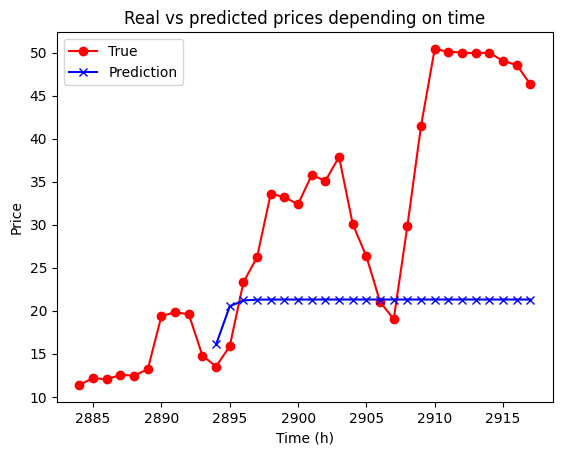

In [14]:
test_dataloader = datamodule.test_dataloader()
predictions, ground_truth = predict(model, test_dataloader)
results = test_model(predictions, ground_truth)
print("Results:", results)

# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(test_split.dataset, predictions)

### With provided data augmentation (synthetic data)

In [15]:
def load_synthetic_datasets(path, max_num_fetched=None):
    if max_num_fetched is not None and max_num_fetched < 0:
        max_num_fetched = None
    train_all = []
    
    i = 0
    for filename in tqdm(os.listdir(path)):
        if max_num_fetched is not None and i >= max_num_fetched:
            break
        i += 1
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            train_all.append(DatasetWithWindow(df_preprocessed, 24, 12, 24, ["dayofweek", "hourofday", "dayofseries", "price"], "price"))
    
    return train_all

In [16]:
directory = "../data/scenarios synthetiques/prix/"
train_all = load_synthetic_datasets(directory, 5)

  3%|▎         | 5/154 [00:09<04:45,  1.92s/it]


In [19]:
train_concat = ConcatDataset(train_all)

train_split_size = int(len(train_concat)*(1-VAL_RATIO))
val_split_size = len(train_concat) - train_split_size

train_split, val_split, _ = get_splits(train_concat, 0, VAL_RATIO)

# test_split is the same (we don't want to test on synthetic data)

datamodule = Datamodule(train_split, val_split, test_split, batch_size=256)

In [22]:
model, _ = train_model(datamodule, **best_params)

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 249.84it/s]

Epoch 49: 100%|██████████| 46/46 [00:00<00:00, 126.29it/s, train_loss=181.0, val_loss=346.0]   


100%|██████████| 1/1 [00:00<?, ?it/s]

Results: {'mse': 247.06581115722656, 'mae': 11.267845153808594, 'rmse': 15.718327522277832}


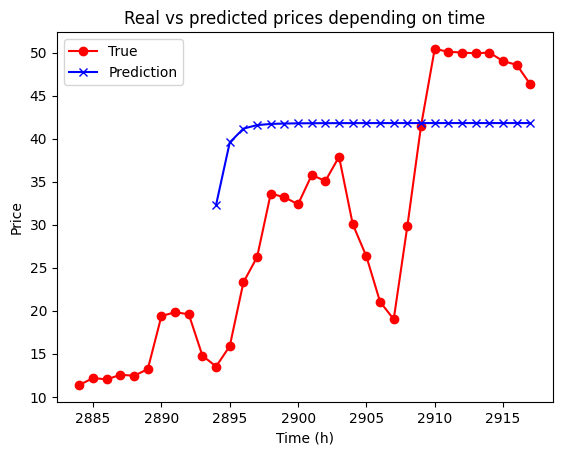

In [23]:
predictions, ground_truth = predict(model, test_dataloader)
results = test_model(predictions, ground_truth)
print("Results:", results)

# take last window ([-1, :])
predictions = predictions.cpu().numpy()[-1, :]

plot_predictions_vs_real(test_split.dataset, predictions)